In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [209]:
df = pd.read_csv('ObesityDataSet-1.csv')

In [210]:
def combine_weight_category(row):
    if row in ['Overweight_Level_I', 'Overweight_Level_II']:
        return 'Overweight'
    elif row in ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']:
        return 'Obesity'
    elif row == 'Normal_Weight':
        return 'Normal'
    elif row == 'Insufficient_Weight':
        return 'Underweight'
    else:
        return row

df['weight'] = df['NObeyesdad'].apply(combine_weight_category)
df['weight'].value_counts()
df.drop(columns=['Weight'], inplace=True)
df.drop(columns=['Height'], inplace=True)
df.drop(columns=['NObeyesdad'], inplace=True)

In [211]:
def clean_split_data(df, target, train_size=0.80, tune_size=0.20, random_state=2):
    # Fill missing numeric values
    df = df.fillna(df.mean(numeric_only=True))

    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Identify categorical and continuous columns in X
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Scale continuous variables
    scaler = StandardScaler()
    X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

    # One-hot encode categorical variables
    dummies = pd.get_dummies(X[categorical_cols], drop_first=True)
    X = pd.concat([X.drop(columns=categorical_cols), dummies], axis=1)

    # Train/temp split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)

    return X_train, X_tune, X_test, y_train, y_tune, y_test

X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(df, 'weight')

In [212]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)
clf = RandomForestClassifier(random_state=1000, n_jobs=-1, class_weight='balanced')

In [ ]:
param_grid = {
    "max_depth": [1, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "n_estimators": [50, 100, 200, 300],
    "max_features": ['sqrt', 'log2'],
}

search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    scoring=['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro'],
    cv=kf,
    n_jobs=-1,
    refit='balanced_accuracy',
)



In [214]:
model = search.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=1000)


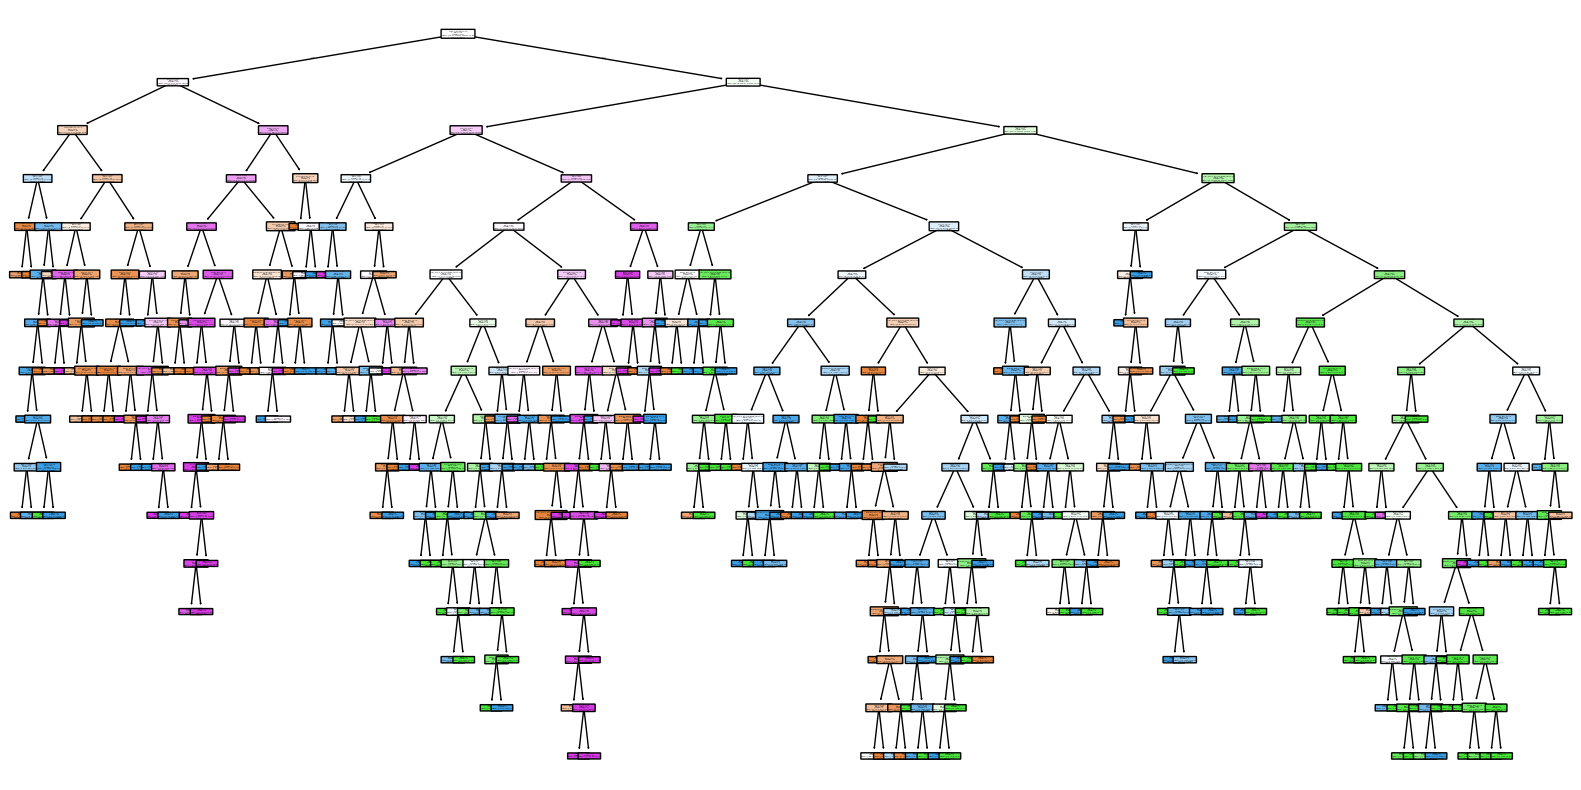

In [215]:
best = model.best_estimator_
print(best)
plt.figure(figsize=(20, 10))
# Visualize the first tree in the random forest
plot_tree(
	best.estimators_[0],
	feature_names=X_train.columns,
	class_names=[str(label) for label in y_train.unique()],
	filled=True,
	rounded=True
)
plt.show()

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1  0.862072  0.843823  0.843823  0.838224    0.027202  0.031503   
1      5  0.856510  0.840318  0.840318  0.832783    0.027192  0.030994   
2     10  0.738969  0.727721  0.727721  0.719102    0.028196  0.029059   
3     15  0.730201  0.719056  0.719056  0.708085    0.029329  0.031084   
4     20  0.828183  0.818917  0.818917  0.806811    0.029650  0.031042   

   bal_accSD      f1SD  
0   0.031503  0.029998  
1   0.030994  0.030557  
2   0.029059  0.029765  
3   0.031084  0.032874  
4   0.031042  0.031971  


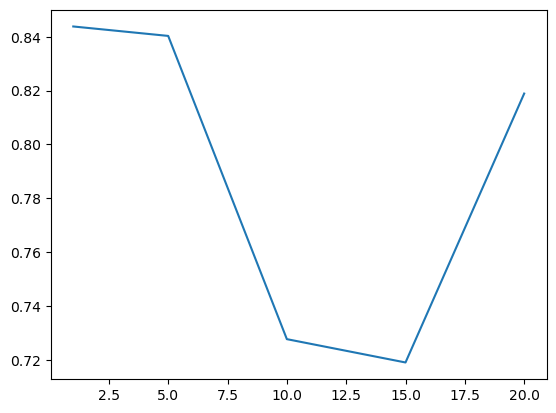

In [216]:
np.random.seed(1)
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)
plt.plot(final_model['depth'], final_model['bal_acc'], label='Balanced Accuracy')

                                    importance
Age                                   0.165127
NCP                                   0.097048
CH2O                                  0.096391
FAF                                   0.093855
TUE                                   0.092235
FCVC                                  0.092023
family_history_with_overweight_yes    0.070856
CAEC_Frequently                       0.048126
CAEC_Sometimes                        0.044231
Gender_Male                           0.040067
MTRANS_Public_Transportation          0.037122
FAVC_yes                              0.026622
CALC_no                               0.025254
CALC_Sometimes                        0.023285
SCC_yes                               0.013088
CALC_Frequently                       0.010041
MTRANS_Walking                        0.009310
CAEC_no                               0.008281
SMOKE_yes                             0.005187
MTRANS_Motorbike                      0.001132
MTRANS_Bike  

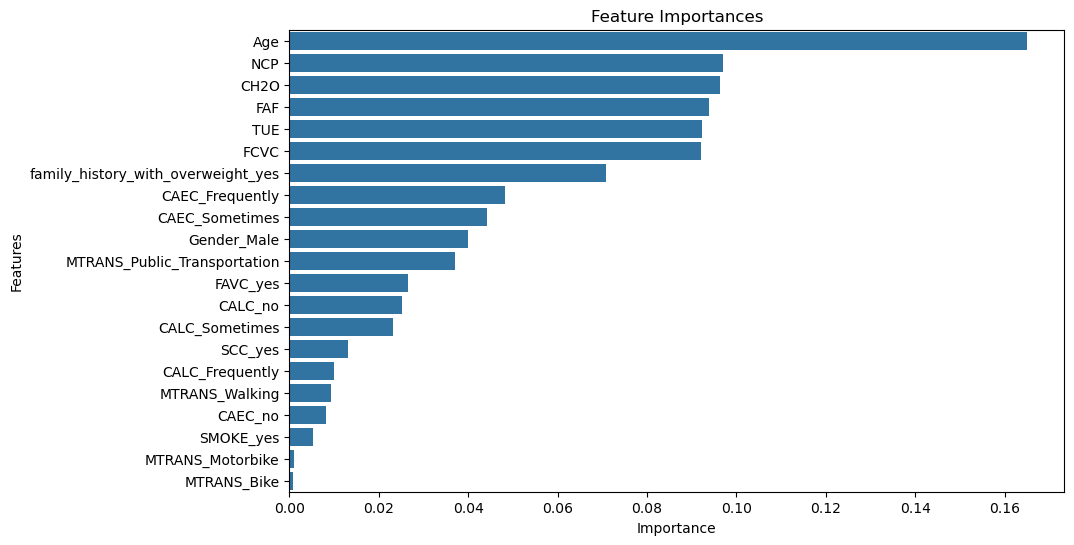

In [217]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Tune Set Performance:
              precision    recall  f1-score   support

      Normal       0.60      0.82      0.69        11
     Obesity       0.95      0.92      0.94        39
  Overweight       0.84      0.70      0.76        23
 Underweight       0.92      1.00      0.96        11

    accuracy                           0.86        84
   macro avg       0.83      0.86      0.84        84
weighted avg       0.87      0.86      0.86        84

Test Set Performance:
              precision    recall  f1-score   support

      Normal       0.67      0.85      0.75        47
     Obesity       0.91      0.94      0.92       156
  Overweight       0.85      0.71      0.77        93
 Underweight       0.95      0.91      0.93        43

    accuracy                           0.86       339
   macro avg       0.84      0.85      0.84       339
weighted avg       0.87      0.86      0.86       339



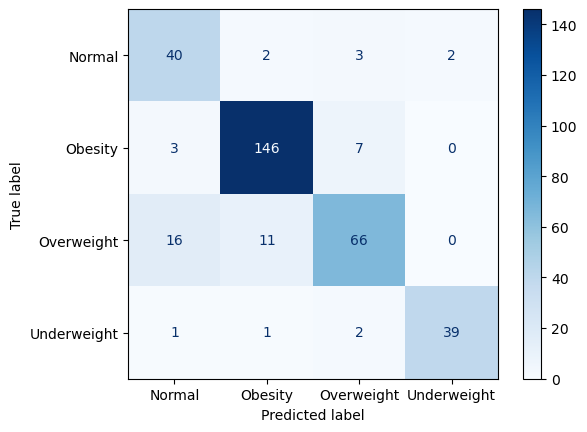

In [218]:
# Predict on tune and test set
y_pred_tune = model.predict(X_tune)
y_pred_test = model.predict(X_test)

print("Tune Set Performance:")
print(classification_report(y_tune, y_pred_tune))

print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues')
plt.show()